# Семестр 2. Задание 3. Распараллеливание рекуррентных соотношений 

In [1]:
import numpy as np

In [2]:
np.random.seed(42)
N = 100
P = 4
A = np.random.rand(100)
B = np.random.rand(100)
X = np.zeros(100)
X[0] = np.random.rand()

## Параллельный алгоритм

In [3]:
import numba
from numba import cuda, njit

In [4]:
@njit
def prepare_x(X, A, B, N, P):
    AA = np.zeros(P-1)
    BB = np.zeros(P-1)
    for i in range(P-1):
        AA[i] = A[N//P*(i+1)] * A[N//P*(i+1)-1]
        BB[i] = A[N//P*(i+1)] * B[N//P*(i+1)-1] + B[N//P*(i+1)]
        for j in range(1, N//P*(i+1)):
            BB[i] = AA[i] * B[j] + BB[i]
            AA[i] = AA[i] * A[j]
        X[N//P*(i+1)] = AA[i] * X[N//P*i]
    return X

In [5]:
@cuda.jit
def parallel_recurrent(X, A, B, P, N):
    idx = cuda.grid(1)
    if idx < P:
        for i in range(N//P*(idx) + 1, N//P*(idx+1)):
            X[i] = A[i] * X[i-1] + B[i]

In [6]:
X = prepare_x(X, A, B, N, P)  
X_dev = cuda.to_device(X)
A_dev = cuda.to_device(A)
B_dev = cuda.to_device(B)

TPB = P
BPG = 1
    
parallel_recurrent[BPG, TPB](X_dev, A_dev, B_dev, P, N)
X_dev.copy_to_host()

/home/bato/miniconda3/envs/p-numba/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([6.42031646e-01, 1.24679908e+00, 1.22700536e+00, 1.24312786e+00,
       1.10151759e+00, 4.21122938e-01, 4.34843264e-01, 1.13220200e+00,
       9.09381785e-01, 7.20888214e-01, 3.04590572e-01, 4.56646684e-01,
       1.30982982e+00, 1.08624848e+00, 8.30910851e-01, 1.02385339e+00,
       1.11517153e+00, 7.71763491e-01, 1.22591839e+00, 8.96365402e-01,
       1.35588392e+00, 1.08522878e+00, 6.35047256e-01, 3.42709008e-01,
       3.84234454e-01, 4.91557545e-13, 8.18014766e-01, 1.28138195e+00,
       7.66061464e-01, 5.46331174e-01, 7.49331695e-01, 3.49886941e-01,
       1.42626070e-01, 4.72950987e-01, 1.39960633e+00, 1.45464097e+00,
       9.61894292e-01, 7.96969208e-01, 9.08942255e-01, 1.37185528e+00,
       1.12986609e+00, 8.11265896e-01, 5.25146740e-01, 7.78404955e-01,
       4.86276114e-01, 3.59055709e-01, 7.21485976e-01, 8.77900807e-01,
       5.31436147e-01, 3.76884804e-01, 9.92181696e-38, 2.39561891e-01,
       3.69963015e-01, 8.20505785e-01, 1.47623085e+00, 1.60295445e+00,
      

## Последовательный

In [7]:
np.random.seed(42)
N = 100
P = 4
A = np.random.rand(100)
B = np.random.rand(100)
X = np.zeros(100)
X[0] = np.random.rand()

In [8]:
def recurrent(X, A, B, N):
    for i in range(1, N):
        X[i] = A[i] * X[i-1] + B[i]
    return X

In [9]:
X = recurrent(X, A, B, N)
print(X)

[0.64203165 1.24679908 1.22700536 1.24312786 1.10151759 0.42112294
 0.43484326 1.132202   0.90938178 0.72088821 0.30459057 0.45664668
 1.30982982 1.08624848 0.83091085 1.02385339 1.11517153 0.77176349
 1.22591839 0.8963654  1.35588392 1.08522878 0.63504726 0.34270901
 0.38423445 0.72879945 0.96353691 1.35621444 0.81039333 0.54839041
 0.75058277 0.35010028 0.14263995 0.47296416 1.39961904 1.45465125
 0.96189742 0.79696951 0.90894246 1.37185538 1.1298661  0.8112659
 0.52514674 0.77840496 0.48627611 0.35905571 0.72148598 0.87790081
 0.53143615 0.3768848  1.2736876  1.22683895 1.29750877 1.6504991
 1.97248383 2.06043729 0.8544688  0.92908086 0.27965735 0.81919737
 0.68618655 0.81850189 1.31185292 1.00378258 0.37228694 1.03734116
 0.46696656 0.56111768 0.08260683 0.67241654 1.19683452 0.25441762
 0.51349798 0.64523357 1.10126088 0.9771935  1.44461811 0.49370159
 1.11370509 0.26656491 0.57113943 0.46946366 1.08003822 0.9459848
 0.55212618 0.83952627 1.42974575 1.4667459  1.83096623 1.1064618

## Сравнение скорости последовательного и параллельного алгоритма

### Последовательно N = 1000

In [10]:
np.random.seed(42)
N = 1000
A = np.random.rand(N)
B = np.random.rand(N)
X = np.zeros(N)
X[0] = np.random.rand()

In [11]:
%%timeit
recurrent(X, A, B, N)

419 μs ± 21.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Параллельный N = 1000, P = 4

In [12]:
np.random.seed(42)
N = 1000
P = 4
A = np.random.rand(N)
B = np.random.rand(N)
X = np.zeros(N)
X[0] = np.random.rand()

X = prepare_x(X, A, B, N, P)  
X_dev = cuda.to_device(X)
A_dev = cuda.to_device(A)
B_dev = cuda.to_device(B)

TPB = P
BPG = 1

In [13]:
%%timeit
parallel_recurrent[BPG, TPB](X_dev, A_dev, B_dev, P, N)

85.2 μs ± 27.6 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Последовательно N = 10 000

In [14]:
np.random.seed(42)
N = 10000
A = np.random.rand(N)
B = np.random.rand(N)
X = np.zeros(N)
X[0] = np.random.rand()

In [15]:
%%timeit
recurrent(X, A, B, N)

4.18 ms ± 261 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Параллельный N = 10 000, P = 4

In [16]:
np.random.seed(42)
N = 10000
P = 4
A = np.random.rand(N)
B = np.random.rand(N)
X = np.zeros(N)
X[0] = np.random.rand()

X = prepare_x(X, A, B, N, P)  
X_dev = cuda.to_device(X)
A_dev = cuda.to_device(A)
B_dev = cuda.to_device(B)

TPB = P
BPG = 1

In [17]:
%%timeit
parallel_recurrent[BPG, TPB](X_dev, A_dev, B_dev, P, N)

1.17 ms ± 48 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Последовательно N = 100 000

In [18]:
np.random.seed(42)
N = 100000
A = np.random.rand(N)
B = np.random.rand(N)
X = np.zeros(N)
X[0] = np.random.rand()

In [19]:
%%timeit
recurrent(X, A, B, N)

40.1 ms ± 656 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Параллельный N = 100 000, P = 4

In [20]:
np.random.seed(42)
N = 100000
P = 4
A = np.random.rand(N)
B = np.random.rand(N)
X = np.zeros(N)
X[0] = np.random.rand()

X = prepare_x(X, A, B, N, P)  
X_dev = cuda.to_device(X)
A_dev = cuda.to_device(A)
B_dev = cuda.to_device(B)

TPB = P
BPG = 1

In [21]:
%%timeit 
parallel_recurrent[BPG, TPB](X_dev, A_dev, B_dev, P, N)

15.7 ms ± 41.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Сравнение результатов по времени

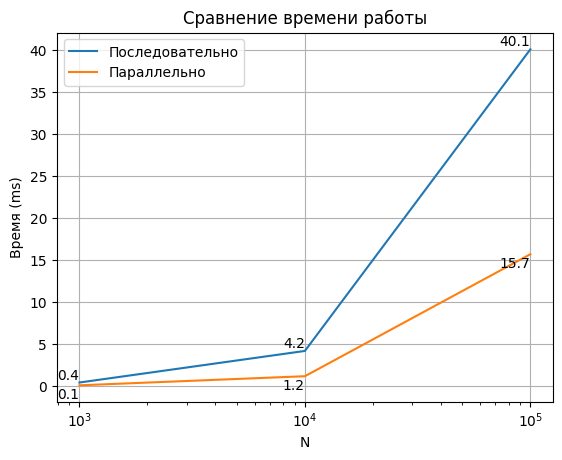

In [28]:
import matplotlib.pyplot as plt

ns = [1000, 10000, 100000]
s_times = [0.419, 4.18, 40.1]
p_times = [0.085, 1.17, 15.7]

plt.plot(ns, s_times)
plt.plot(ns, p_times)
for x, y in zip(ns, s_times):
    plt.text(x, y, f'{y:.1f}', ha='right', va='bottom')

for x, y in zip(ns, p_times):
    plt.text(x, y-2, f'{y:.1f}', ha='right', va='bottom')
plt.title("Сравнение времени работы")
plt.xlabel("N")
plt.ylabel("Время (ms)")
plt.xscale('log')
plt.grid(True)
plt.legend(['Последовательно', 'Параллельно'])
plt.xticks(ns)
plt.show()